# makemore: part 3 - gradients and activations

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [9]:
# read all words
words = open('../names.txt', "r").read().splitlines()

In [10]:
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [11]:
# build vocabulary of characters and mappings to and from ints:
chars = ["."] + sorted(set(''.join(words)))
itos = {k:v for k,v in enumerate(chars)}
stoi = {v:k  for k,v in itos.items()}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [19]:
# build the dataset
block_size = 3
words = open('../names.txt', "r").read().splitlines()

def build_dataset(words):
    X, Y = [],[]
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            ix = stoi[char]
            # print ("".join([itos[c] for c in context]), "->", char)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [89]:
#MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [90]:
# same optimisation but with parameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break


      0/ 200000: 27.8817


In [26]:
# initial loss in 27.9 which is very high. If it were a uniform loss that it would be as follows:
-torch.tensor(1/27.0).log() # 3.29

tensor(3.2958)

In [88]:
# 4 dimensional example of the issue
# changes: 1. random, 2.random * 10 or 100, 3. extreme values, 4. uniform
# logits = torch.randn(4) * 10 0
logits_4d = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits_4d, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-3.,  5.,  0.,  2.]),
 tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]),
 tensor(5.0553))

In [93]:
# this is the loss after the first iteration in the model and the weights of the logits: 
loss, logits[0]

(tensor(27.8817, grad_fn=<NllLossBackward0>),
 tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
           1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
          -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
          14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
        grad_fn=<SelectBackward0>))

In [104]:
#MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # setting these weights initial to minimise initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # minimise initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [105]:
# same optimisation but with parameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


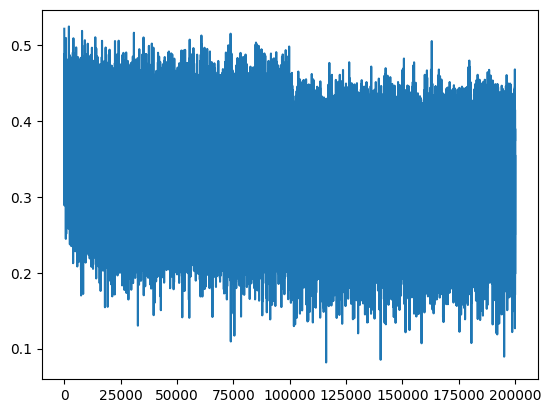

In [106]:
plt.plot(lossi)

In [19]:
# function to calculate the losses for each data set. 
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtr, Yte)
    }[split]

    emb = C[x] # load examples and embed the char vector
    embcat = emb.view(emb.shape[0], -1) # adjust shape 
    h = torch.tanh(embcat @ W1 + b1) # matmul: (samples, block_size * emb) @ (block_size * emb, n_hidden), h: samples, n_hidden
    logits = h @ W2 + b2 #(samples, 27)
    loss= F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.106989622116089


In [12]:
# fixing the saturated tanh 
# setup again: 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # setting these weights initial to minimise initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # minimise initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [13]:
# break after first 
# same optimisation but with parameters, and 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3221


In [15]:
# look into the initialisation
# h has values -1, 1 in some cases:
h, h.shape

(tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
         [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
         [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
         ...,
         [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
         [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
         [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

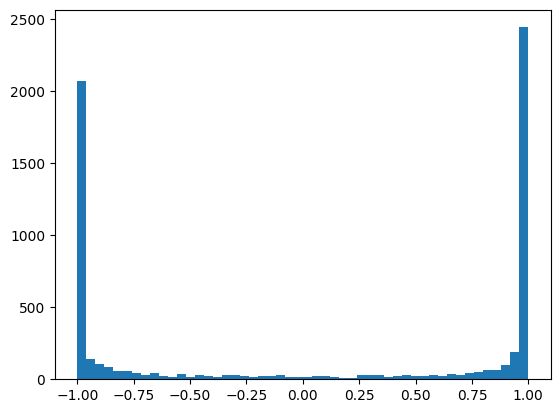

In [18]:
# histogram of h values - in 50 bins
# this is bad! as for tanh(x) = -1 and 1the gradient is ~ 0 so optimisation is stuck. derivative of tanh(x) is 1-tanhb^2
# this means that there is no impact to the loss
plt.hist(h.view(-1).tolist(), 50);

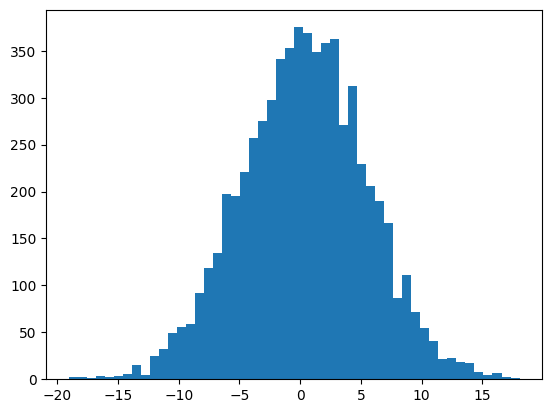

In [40]:
# the pre activations are too broad here: 
plt.hist(hpreact.view(-1).tolist(), 50);

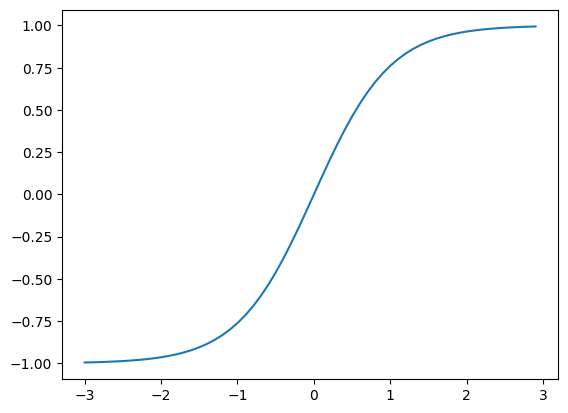

In [41]:
## if the tanh value is on the flat bits of the curve then the gradient ~ 0 and any passing through
# gradient is destroyed as it's x 0. If the tanh(x) = 0 the the gradient is 1 and all gradients pass through and impact the loss
# gradient is 'squashed' in the flat regions, ie I think reduced?!j

x = torch.arange(-3,3,0.1)
plt.plot(x, torch.tanh(x));

In [42]:
x = torch.arange(-5,5,1)
torch.tanh(x),x

(tensor([-0.9999, -0.9993, -0.9951, -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,
          0.9951,  0.9993]),
 tensor([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4]))

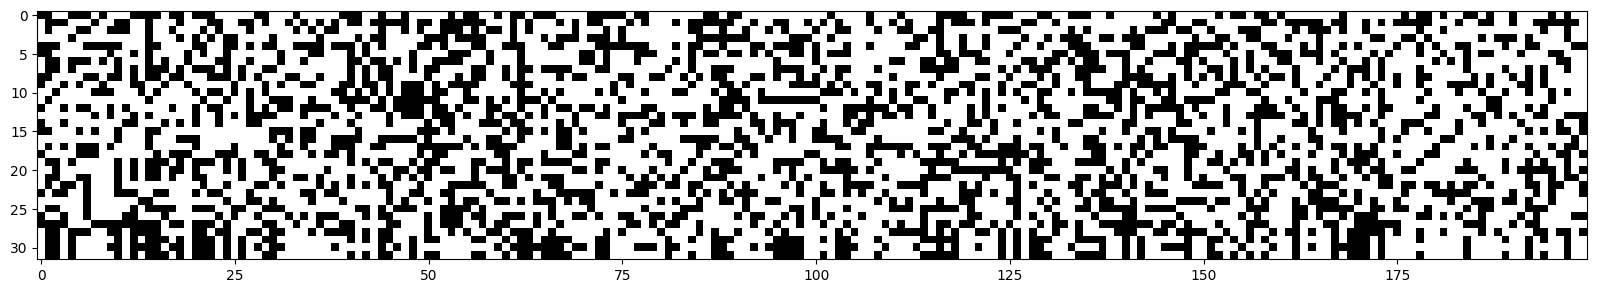

In [43]:
# this shows for the batch of 32, every neuron (200) in black where neuron in the flat part of the curve, i.e. grad = 0
# white are where grad is 0, -1 or +1 and effectively dead. Black means in a good zone for optimisation.
# if all column is white, for each training example, then neuron is dead. It will never be active. 
# other activiation functions have the same problem like sigmoid, reLU, ELU not leaky ReLU.
# this can happen at initialiation or during optimisation - if the learning rate is too high, the neuron can get knocked out. 
# this no example activiates this neuron, so it's dead
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap ='gray', interpolation='nearest');


In [55]:
# to fix - we need to fix the preactivation. so can make it close to zero by setting b1 to 0-0.01
# and W1 lower
# rerun with this: 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # setting to lower for less extreme pre optimisation
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # setting these weights initial to minimise initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # minimise initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [56]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3135


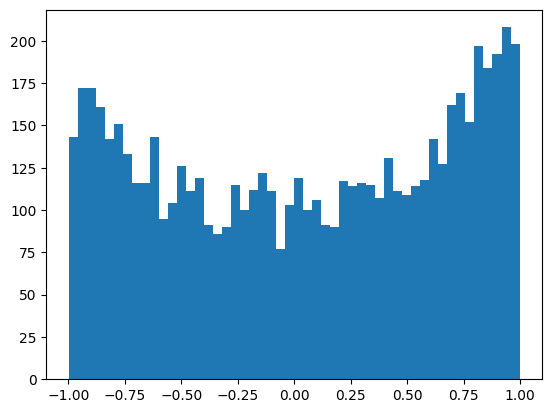

In [57]:
plt.hist(h.view(-1).tolist(), 50);

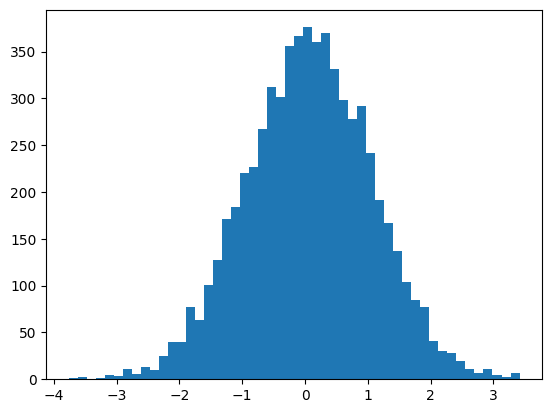

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50);

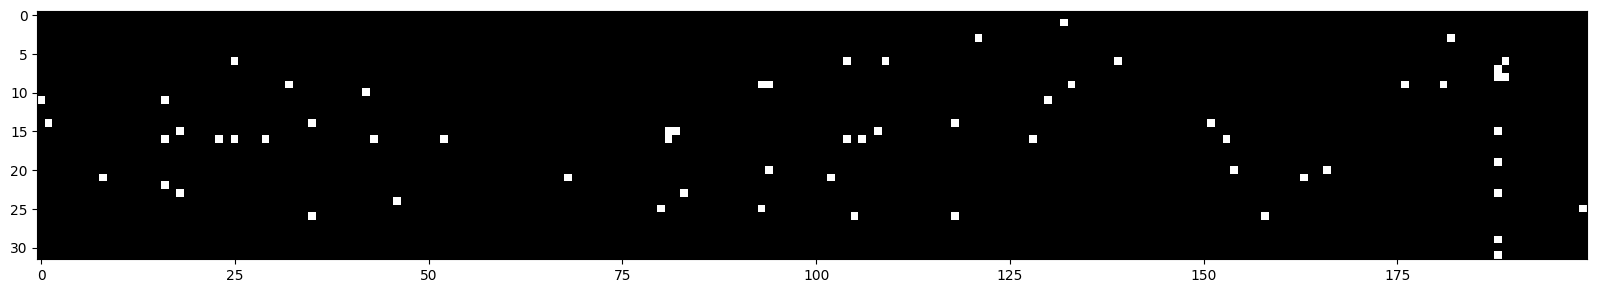

In [59]:
# not much white: 
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap ='gray', interpolation='nearest');

In [6]:
# now run training runs: 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # setting to lower for less extreme pre optimisation
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # setting these weights initial to minimise initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # minimise initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [61]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


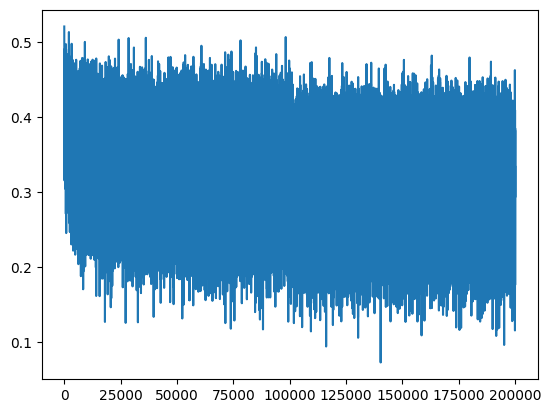

In [63]:
plt.plot(lossi);

In [65]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


In [ ]:
# loss log
# original 
train: 2.1234
val:   2.168

# fix softmax confidently wrong: 
train: 2.07
val:   2.13

# fix tanh layer too saturated at init:
train:  2.04
val:    2.10

In [ ]:
# this is easy to fix for a simple network with 1 layer, but much more complex for multiple layers
# the network still learned even though. if you have 50 layers, prob is more complex and problems stack in
# deeper networks may not learn because of this. 

In [ ]:
# how do you set this init values? We don't do it by hand

tensor(-0.0018) tensor(1.0011)
tensor(-0.0044) tensor(3.2004)


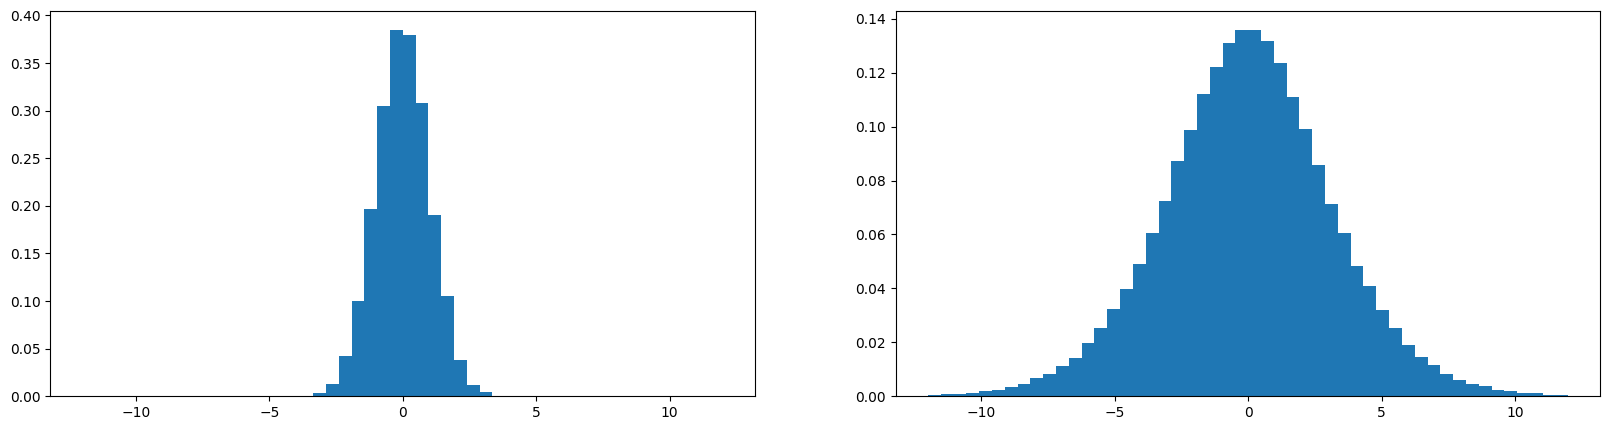

In [8]:
# guassian is expanding from std dev 1 to std dev 3
# ideally we want to perserve the guassina std dev
x = torch.randn(1000, 10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, range=(-12,12));
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, range=(-12,12));


tensor(-0.0035) tensor(0.9884)
tensor(3.3259e-05) tensor(0.9825)


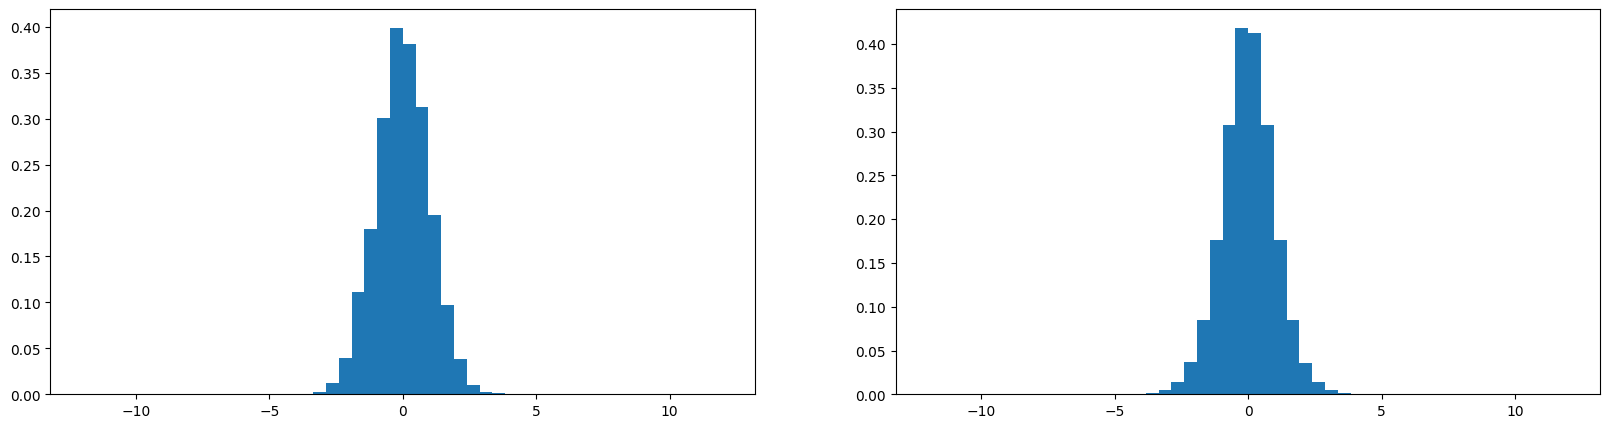

In [10]:
# to perserve the 
x = torch.randn(1000, 10)
w = torch.randn(10,200) / 10**0.5 # divide the weights by sqrt of fan in
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, range=(-12,12));
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, range=(-12,12));

In [13]:
# see kaiming_normal in torch torch.nn.init. the gain is dependeny t on the nonlinaerity function used (tanh, RELu, etc).
# modern techniques such as normalisation layers and other optimistion mean this is now less important, but still need to be set.

# this scales the guassian by 0.2: 
x = torch.randn(10000)
x.std(), (x * 0.2).std() 


(tensor(0.9946), tensor(0.1989))

In [15]:
# for tann and fanin of 10 x 3 (  characters 10 dimension) we have and we can use this in our weight inits
(5/3) / (30**0.5)

0.3042903097250923

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the 
vocab_size = len(stoi) # the number of distinct characters 

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) 
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # setting these weights initial to minimise initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # minimise initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [17]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]    
    
    # forward pass
    emb = C[Xb] # emb chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every so often
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


In [20]:
split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.106989622116089


In [7]:
# sample from the model. start with context and predict next char index, by passing in context to model, generating the logits 
# using softmax to convert them to a prob distribution. select char indexes from the prob randomly and add these to a result out array
# print out the array when predicted char index ref to '.' is returned
    
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor(context)]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponent of logits and sum so each distribution sums to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # select one char index from distribution based on probs
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))


NameError: name 'C' is not defined

In [27]:
# the initial los is very high and not respresentative. it's 27.5
# the expected loss if distributed probability:
-torch.tensor(1/27.0).log().item()

3.295836925506592

In [40]:
# 4 dim example of issue: 
# logits = torch.tensor([0.0,0.0,0.0,0.0])
# logits = torch.tensor([-3.0,5.0,0.0,2.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([7.6612e-03, 5.7636e-02, 1.2090e-05, 9.3469e-01]), tensor(11.3231))